# House Prices - Advanced Regression Techniques

## Import library and datasets

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.cluster import KMeans

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/house-prices-advanced-regression-techniques/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
raw_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
isna_sr = raw_df.isna().sum()
isna_sr[isna_sr>0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

def view_avg_of_each(cat_features: str, target: str, df):
    d = dict()
    cols = df[cat_features].unique()
    for x in cols:
        d[x] = df[df[cat_features]==x][target].mean()
    return pd.Series(d, index=cols)

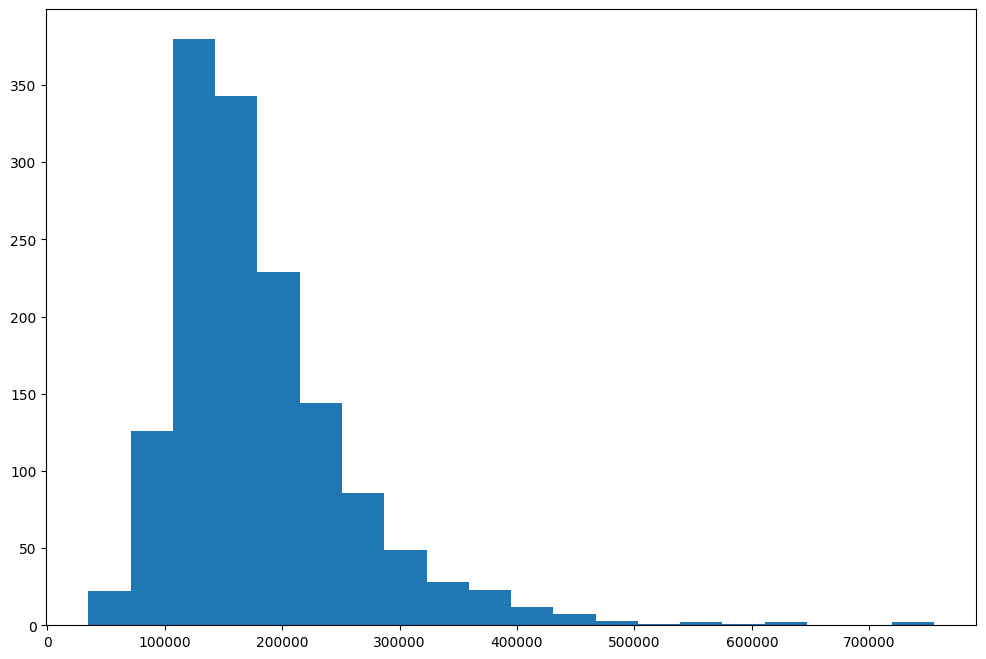

In [6]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['SalePrice'], bins=20);

## EDA and Feature Engineering

In [7]:
target = 'SalePrice'

In [8]:
concat_df = pd.concat([raw_df,test_df]).copy()
concat_df.index = concat_df['Id']
concat_df.drop(columns='Id')
concat_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN


### LotFrontage & LotArea

In [9]:
concat_df[['LotFrontage','LotArea']].isna().sum()

LotFrontage    486
LotArea          0
dtype: int64

In [10]:
concat_df[['LotFrontage','LotArea']].describe()

,LotFrontage,LotArea
count,2433.000000,2919.000000
mean,69.305795,10168.114080
std,23.344905,7886.996359
min,21.000000,1300.000000
25%,59.000000,7478.000000
50%,68.000000,9453.000000
75%,80.000000,11570.000000
max,313.000000,215245.000000


In [11]:
avg = concat_df['LotFrontage'].mean()
concat_df.fillna({'LotFrontage':avg}, inplace=True)

In [12]:
concat_df['LotArea_LotFrontAge_Divide'] = concat_df['LotArea']/concat_df['LotFrontage']

In [13]:
kmeans = KMeans(n_clusters=6)
concat_df['LotFrontage_LotArea_Cluster'] = kmeans.fit_predict(concat_df[['LotFrontage','LotArea']])
concat_df['LotFrontage_LotArea_Cluster'].value_counts()

LotFrontage_LotArea_Cluster
0    1571
3     705
4     527
5      90
2      22
1       4
Name: count, dtype: int64

In [14]:
view_avg_of_each('LotFrontage_LotArea_Cluster', target, concat_df)

0    167565.519796
3    228421.265928
4    138295.291339
2    300173.076923
5    228196.955556
1    295737.500000
dtype: float64

### OverallQual & OverallCond

In [15]:
def get_overall_merge(x, y):
    if x>=6 and y>=6:
        return 2
    if x<=4 and y<=4:
        return 0
    return 1
concat_df['OverallQual_OverallCond_Merge'] = concat_df[['OverallQual','OverallCond']].apply(lambda x: get_overall_merge(x['OverallQual'],x['OverallCond']),axis=1)
concat_df['OverallQual_OverallCond_Merge'].value_counts()

OverallQual_OverallCond_Merge
1    2311
2     531
0      77
Name: count, dtype: int64

In [16]:
view_avg_of_each('OverallQual_OverallCond_Merge',target,concat_df)

1    182706.114211
2    186878.055147
0     91468.341463
dtype: float64

### YearBuilt, YearRemodAdd

In [17]:
concat_df['YearBuilt'].describe()

count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
25%      1953.500000
50%      1973.000000
75%      2001.000000
max      2010.000000
Name: YearBuilt, dtype: float64

In [18]:
concat_df['YearRemodAdd'].describe()

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
25%      1965.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

In [19]:
for col in ['YearBuilt','YearRemodAdd']:
    concat_df[col] = concat_df[col].apply(lambda x: 2020-x)

### BsmtSF

In [20]:
bsmt_sfs = ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']

In [21]:
concat_df[bsmt_sfs]

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
Id,,,,
1,706.0,0.0,150.0,856.0
2,978.0,0.0,284.0,1262.0
3,486.0,0.0,434.0,920.0
4,216.0,0.0,540.0,756.0
5,655.0,0.0,490.0,1145.0
...,...,...,...,...
2915,0.0,0.0,546.0,546.0
2916,252.0,0.0,294.0,546.0
2917,1224.0,0.0,0.0,1224.0


In [22]:
concat_df[bsmt_sfs].isna().sum()

BsmtFinSF1     1
BsmtFinSF2     1
BsmtUnfSF      1
TotalBsmtSF    1
dtype: int64

In [23]:
avg = concat_df[bsmt_sfs].mean()
concat_df.fillna({
    'BsmtFinSF1': avg.get('BsmtFinSF1'),
    'BsmtFinSF2': avg.get('BsmtFinSF2'),
    'BsmtUnfSF': avg.get('BsmtUnfSF'),
    'TotalBsmtSF': avg.get('TotalBsmtSF')
}, inplace=True)

In [24]:
bsmt_sfs.remove('TotalBsmtSF')

In [25]:
kmeans = KMeans(n_clusters=7)
concat_df['Bsmt_Cluster'] = kmeans.fit_predict(concat_df[bsmt_sfs])
concat_df['Bsmt_Cluster'].value_counts()

Bsmt_Cluster
1    704
3    651
0    473
6    330
4    321
2    290
5    150
Name: count, dtype: int64

In [26]:
view_avg_of_each('Bsmt_Cluster',target,concat_df)

3    171445.003021
0    173908.130435
2    294220.634483
1    152913.676966
4    227736.539877
6    123836.601449
5    163353.040541
dtype: float64

### FloorSF

In [27]:
flr_sfs = ['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea']

In [28]:
concat_df[flr_sfs].isna().sum()

1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
GrLivArea       0
dtype: int64

In [29]:
flr_sfs.remove('GrLivArea')

In [30]:
kmeans = KMeans(n_clusters=7)
concat_df['Flr_Cluster'] = kmeans.fit_predict(concat_df[flr_sfs])
concat_df['Flr_Cluster'].value_counts()

Flr_Cluster
6    632
2    550
0    509
3    480
1    459
4    208
5     81
Name: count, dtype: int64

In [31]:
view_avg_of_each('Flr_Cluster',target,concat_df)

0    194691.740876
2    162095.094340
3    138846.197248
1    234399.811404
6    118556.472393
4    300122.736364
5    319735.128205
dtype: float64

### GarageCars & GarageArea

In [32]:
concat_df[['GarageCars','GarageArea']].isna().sum()

GarageCars    1
GarageArea    1
dtype: int64

In [33]:
concat_df['GarageCars'].mode().get(0), concat_df['GarageArea'].mean()

(2.0, 472.8745716244003)

In [34]:
concat_df.fillna({
    'GarageCars': concat_df['GarageCars'].mode().get(0),
    'GarageArea': concat_df['GarageArea'].mean()
},inplace=True)

In [35]:
concat_df[['GarageCars','GarageArea']].describe()

,GarageCars,GarageArea
count,2919.000000,2919.000000
mean,1.766701,472.874572
std,0.761506,215.357904
min,0.000000,0.000000
25%,1.000000,320.000000
50%,2.000000,480.000000
75%,2.000000,576.000000
max,5.000000,1488.000000


In [36]:
def get_area_per_car(cars, area):
    if cars == 0 or area == 0:
        return 0
    return area/cars

concat_df['Garage_Area_per_Car'] = concat_df[['GarageCars','GarageArea']].apply(lambda x: get_area_per_car(x['GarageCars'],x['GarageArea']),axis=1)

In [37]:
concat_df['Garage_Area_per_Car'].describe()

count    2919.000000
mean      257.639056
std        85.918497
min         0.000000
25%       226.583333
50%       262.666667
75%       294.000000
max       924.000000
Name: Garage_Area_per_Car, dtype: float64

### Other SF

In [38]:
other_sfs = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']

In [39]:
concat_df[other_sfs].isna().sum()

WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
dtype: int64

In [40]:
kmeans = KMeans(n_clusters=7)
concat_df['Other_SF_Cluster'] = kmeans.fit_predict(concat_df[other_sfs])
concat_df['Other_SF_Cluster'].value_counts()

Other_SF_Cluster
3    1057
1     759
5     336
6     265
0     229
4     183
2      90
Name: count, dtype: int64

In [41]:
view_avg_of_each('Other_SF_Cluster',target,concat_df)

3    152484.423729
5    211167.318182
6    145455.455882
1    204752.840000
4    213158.517241
0    185013.360360
2    235562.227273
dtype: float64

## Preprocessing

### Impute missing values

In [42]:
isna_sr = concat_df.isna().sum()
isna_sr[isna_sr>0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

In [43]:
concat_df['GarageYrBlt'] = concat_df['GarageYrBlt'].apply(lambda x: 2020-x if x<2020 else 0)

In [44]:
concat_df['GarageYrBlt'] = concat_df['GarageYrBlt'].astype('int64')

In [45]:
imputer = SimpleImputer(strategy='mean')
concat_df[['MasVnrArea','GarageYrBlt']] = imputer.fit_transform(concat_df[['MasVnrArea','GarageYrBlt']])

In [46]:
isna_sr = concat_df.isna().sum()
cols = isna_sr[(isna_sr>0) & (isna_sr<10)].index.tolist()
imputer = SimpleImputer(strategy='most_frequent')
concat_df[cols] = imputer.fit_transform(concat_df[cols])

In [47]:
isna_sr = concat_df.isna().sum()
cols = isna_sr[isna_sr>0].index.tolist()
cols.remove('SalePrice')
imputer = SimpleImputer(strategy='constant',fill_value='unk')
concat_df[cols] = imputer.fit_transform(concat_df[cols])

### Encode cat features

In [48]:
cat_features = concat_df.select_dtypes(include='object').columns.tolist()
cat_features.append('MSSubClass')

In [49]:
for col in ['BsmtFullBath','BsmtHalfBath']:
    concat_df[col] = concat_df[col].astype('int64')

In [50]:
cat_features.remove('BsmtFullBath')
cat_features.remove('BsmtHalfBath')

In [51]:
encoder = OrdinalEncoder()
concat_df[cat_features] = encoder.fit_transform(concat_df[cat_features])

In [52]:
for f in cat_features:
    concat_df[f] = concat_df[f].astype('int64')

In [53]:
concat_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,LotArea_LotFrontAge_Divide,LotFrontage_LotArea_Cluster,OverallQual_OverallCond_Merge,Bsmt_Cluster,Flr_Cluster,Garage_Area_per_Car,Other_SF_Cluster
Id,,,,,,,,,,,,,,,,,,,,,
1,1,5,3,65.0,8450,1,2,3,3,0,...,8,4,208500.0,130.000000,0,1,3,0,274.000000,3
2,2,0,3,80.0,9600,1,2,3,3,0,...,8,4,181500.0,120.000000,0,2,3,2,230.000000,5
3,3,5,3,68.0,11250,1,2,0,3,0,...,8,4,223500.0,165.441176,3,1,0,0,304.000000,3
4,4,6,3,60.0,9550,1,2,0,3,0,...,8,0,140000.0,159.166667,0,1,0,0,214.000000,6
5,5,5,3,84.0,14260,1,2,0,3,0,...,8,4,250000.0,169.761905,3,1,0,0,278.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2915,13,4,21.0,1936,1,2,3,3,0,...,8,4,NaN,92.190476,4,1,1,3,0.000000,3
2916,2916,13,4,21.0,1894,1,2,3,3,0,...,8,0,NaN,90.190476,4,1,6,3,286.000000,3
2917,2917,0,3,160.0,20000,1,2,3,3,0,...,8,0,NaN,125.000000,5,1,2,2,288.000000,2


In [54]:
input_cols = concat_df.columns.tolist()
input_cols.remove('Id')
input_cols.remove('SalePrice')
len(input_cols)

86

### Scale

In [55]:
scale_cols = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
              'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
              'GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal',
              'YrSold','LotArea_LotFrontAge_Divide','Garage_Area_per_Car',
              'YearBuilt','YearRemodAdd']
len(scale_cols)

25

In [56]:
scaler = MinMaxScaler(feature_range=(0,7))
scaler.fit(concat_df[scale_cols])

MinMaxScaler(feature_range=(0, 7))

In [57]:
concat_df[scale_cols] = scaler.transform(concat_df[scale_cols])

### Split raw and test, view mutual info

In [58]:
raw_max_idx = raw_df['Id'].max()

In [59]:
raw_df = concat_df[concat_df['Id']<=raw_max_idx].copy()
test_df = concat_df[concat_df['Id']>raw_max_idx].copy()

In [60]:
inputs, targets = raw_df[input_cols], raw_df[target].astype('int64')

In [61]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )

CPU times: user 17.3 s, sys: 904 ms, total: 18.2 s
Wall time: 18.2 s


In [62]:
mutual_info.head(8)

,Numerical_Feature_MI
PoolQC,3.255945
RoofMatl,3.144530
Condition2,3.058057
MiscFeature,3.003508
Street,2.980583
KitchenAbvGr,2.861980
Alley,2.856693
Heating,2.830507


In [63]:
mutual_info.tail(8)

,Numerical_Feature_MI
BsmtUnfSF,0.015068
BsmtFinSF2,0.014392
PoolArea,0.014189
LowQualFinSF,0.001124
ScreenPorch,0.000000
LandSlope,0.000000
Utilities,0.000000
BldgType,0.000000


In [64]:
all_features = input_cols.copy()

In [65]:
len(all_features)

86

In [66]:
for non_info_f in ['LowQualFinSF','ScreenPorch','LandSlope','Utilities','BldgType']:
    all_features.remove(non_info_f)
len(input_cols)

86

## Traning model and tuning hyperparameters

In [67]:
def cross_validation(reg, cv, inputs, targets, test_inputs=None, need_print=False):
    train_losses = []
    val_losses = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        reg.fit(X_train, y_train)

        train_pred = pd.Series(reg.predict(X_train)).apply(lambda x: 0 if x<0 else x)
        train_loss = np.sqrt(mean_squared_log_error(y_train, train_pred))
        train_losses.append(train_loss)
        val_pred = pd.Series(reg.predict(X_val)).apply(lambda x: 0 if x<0 else x)
        val_loss = np.sqrt(mean_squared_log_error(y_val, val_pred))
        val_losses.append(val_loss)

        if need_print:
            print(f'Fold {fold}: train_loss = {train_loss:.5f}, val_loss = {val_loss:.5f}')

        if test_inputs is not None:
            test_pred = reg.predict(test_inputs)
            test_preds += test_pred/cv.get_n_splits()

    m_train_loss = np.mean(train_losses)
    s_train_loss = np.std(train_losses)
    m_val_loss = np.mean(val_losses)
    s_val_loss = np.std(val_losses)
    
    msg = f'{m_val_loss:.7f} ± {s_val_loss:.7f}'
    
    if need_print:
        print(f'Train loss: {m_train_loss:.7f} ± {s_train_loss:.7f} | Val loss: {m_val_loss:.7f} ± {s_val_loss:.7f}')
    return test_preds, msg

In [68]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Regressor'] = []
    for feature, _ in features.items():
        result[f'RMSE with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Regressor'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                      inputs, targets, 
                                      test_inputs=None, 
                                      need_print=False)
            result[f'RMSE with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [69]:
regressors = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_jobs=-1),
    'XGBRegressor': XGBRegressor(n_jobs=-1),
    'LGBMRegressor': LGBMRegressor(n_jobs=-1, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent')
}
features = {
    'all': all_features
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [70]:
%%time
test_with_models(regressors, features, raw_df, 'SalePrice', cv)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

CPU times: user 1min 14s, sys: 6.71 s, total: 1min 21s
Wall time: 33.3 s


,Regressor,RMSE with all features
0,LinearRegression,0.3420511 ± 0.3345974
1,DecisionTreeRegressor,0.2115319 ± 0.0059297
2,RandomForestRegressor,0.1477675 ± 0.0163637
3,XGBRegressor,0.1437943 ± 0.0156298
4,LGBMRegressor,0.1374621 ± 0.0134985
5,CatBoostRegressor,0.1257141 ± 0.0141226


So we try with RandomForest, LGBM, CatBoost

### RandomForestRegressor

In [71]:
param_dis = {
    'n_estimators': np.arange(50,500,50),
    'max_depth': np.arange(10,70,6),
    'min_samples_split': np.arange(2,6),
    'min_samples_leaf': np.arange(1,5),
    'max_features': ['sqrt','log2',None],
    'min_weight_fraction_leaf': loguniform(1e-6,0.4),
    'max_leaf_nodes': np.arange(20,600,45),
    'n_jobs': [-1],
    'random_state': [0,17,42,123,1212],
    'max_samples': loguniform(0.2,1)
}

In [72]:
'''%%time
search = RandomizedSearchCV(RandomForestRegressor(),
                            param_dis,
                            n_iter=150,
                            scoring='neg_mean_squared_log_error', cv=cv,
                            refit=True, verbose=3)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(RandomForestRegressor(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='neg_mean_squared_log_error', cv=cv,\n                            refit=True, verbose=3)\ninputs, targets = raw_df[all_features], raw_df['SalePrice']\ntest_inputs = test_df[all_features]\nsearch.fit(inputs, targets)"

In [73]:
best_params = {
 'max_depth': 58,
 'max_features': None,
 'max_leaf_nodes': 560,
 'max_samples': 0.9072359965528524,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 1.1128876112819692e-06,
 'n_estimators': 400,
 'n_jobs': -1,
 'random_state': 42
}

In [74]:
%%time
reg = RandomForestRegressor(**best_params)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 0.08288, val_loss = 0.16987
Fold 1: train_loss = 0.08203, val_loss = 0.15184
Fold 2: train_loss = 0.08727, val_loss = 0.12814
Fold 3: train_loss = 0.08700, val_loss = 0.13245
Fold 4: train_loss = 0.08374, val_loss = 0.15963
Train loss: 0.0845833 ± 0.0021524 | Val loss: 0.1483858 ± 0.0158965
CPU times: user 31.9 s, sys: 59.8 ms, total: 32 s
Wall time: 32 s


In [75]:
sub_df['SalePrice'] = test_preds
sub_df.to_csv('/kaggle/working/sub_rf.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     179089.770427
std       72006.262685
min       63544.172378
25%      130841.360239
50%      158752.680674
75%      209600.279347
max      497524.336999
Name: SalePrice, dtype: float64

### LGBMRegressor

In [76]:
param_dis = {
    'num_leaves': np.arange(32,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(50,341,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(15,55,4),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(14,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [-1]
}

In [77]:
'''%%time
search = RandomizedSearchCV(LGBMRegressor(),
                            param_dis,
                            n_iter=150,
                            scoring='neg_mean_squared_log_error', cv=cv,
                            refit=True, verbose=3)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(LGBMRegressor(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='neg_mean_squared_log_error', cv=cv,\n                            refit=True, verbose=3)\ninputs, targets = raw_df[all_features], raw_df['SalePrice']\ntest_inputs = test_df[all_features]\nsearch.fit(inputs, targets)"

In [78]:
best_params = {
 'colsample_bytree': 0.3758505807831109,
 'learning_rate': 0.025172541401115973,
 'max_depth': 35,
 'min_child_samples': 26,
 'min_child_weight': 0.0001115968142335559,
 'min_split_gain': 0.0017346920635754118,
 'n_estimators': 290,
 'n_jobs': -1,
 'num_leaves': 81,
 'random_state': 42,
 'reg_alpha': 9.808308247121393e-05,
 'reg_lambda': 1.864868733111634e-05,
 'subsample': 0.3363131845770683,
 'verbose': -1
}

In [79]:
%%time
reg = LGBMRegressor(**best_params)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 0.06546, val_loss = 0.14558
Fold 1: train_loss = 0.06690, val_loss = 0.13546
Fold 2: train_loss = 0.07203, val_loss = 0.12015
Fold 3: train_loss = 0.07231, val_loss = 0.11876
Fold 4: train_loss = 0.06889, val_loss = 0.14013
Train loss: 0.0691176 ± 0.0027206 | Val loss: 0.1320162 ± 0.0107545
CPU times: user 2.75 s, sys: 7.65 ms, total: 2.76 s
Wall time: 2.75 s


In [80]:
sub_df['SalePrice'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     179021.293420
std       75515.947027
min       56356.150110
25%      128504.166728
50%      159018.211013
75%      210877.380521
max      487664.845385
Name: SalePrice, dtype: float64

### CatBoostRegressor

In [81]:
param_dis = {
    'eval_metric': ['RMSE'],
    'iterations': np.arange(750,2500,250),
    'learning_rate': loguniform(0.005,0.1),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,4),
    'border_count': np.arange(24,296,50),
    'logging_level': ['Silent']
}

In [82]:
'''%%time
search = RandomizedSearchCV(CatBoostRegressor(),
                            param_dis,
                            n_iter=150,
                            scoring='neg_mean_squared_log_error', cv=cv,
                            refit=True, verbose=3)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(CatBoostRegressor(),\n                            param_dis,\n                            n_iter=150,\n                            scoring='neg_mean_squared_log_error', cv=cv,\n                            refit=True, verbose=3)\ninputs, targets = raw_df[all_features], raw_df['SalePrice']\ntest_inputs = test_df[all_features]\nsearch.fit(inputs, targets)"

In [83]:
best_params = {
 'bagging_temperature': 0.9941368192771662,
 'border_count': 124,
 'depth': 6,
 'eval_metric': 'RMSE',
 'iterations': 2000,
 'l2_leaf_reg': 7.797320124613558,
 'learning_rate': 0.017764286686603632,
 'logging_level': 'Silent',
 'min_data_in_leaf': 1,
 'random_seed': 42,
 'random_strength': 3
}

In [84]:
%%time
reg = CatBoostRegressor(**best_params)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 0.05665, val_loss = 0.14123
Fold 1: train_loss = 0.06103, val_loss = 0.13163
Fold 2: train_loss = 0.06037, val_loss = 0.10726
Fold 3: train_loss = 0.06244, val_loss = 0.11497
Fold 4: train_loss = 0.05910, val_loss = 0.13207
Train loss: 0.0599172 ± 0.0019591 | Val loss: 0.1254325 ± 0.0124236
CPU times: user 1min 24s, sys: 10.9 s, total: 1min 35s
Wall time: 24.9 s


In [85]:
sub_df['SalePrice'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     179120.958389
std       75156.910567
min       49032.792333
25%      129315.739738
50%      159285.158649
75%      210251.494687
max      495105.694485
Name: SalePrice, dtype: float64

In [86]:
cat_f = raw_df[all_features].select_dtypes(include=['int32','int64']).columns.tolist()
len(cat_f)

57

In [87]:
%%time
reg = CatBoostRegressor(**best_params, cat_features=cat_f)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 0.08659, val_loss = 0.14775
Fold 1: train_loss = 0.08770, val_loss = 0.13875
Fold 2: train_loss = 0.09174, val_loss = 0.11401
Fold 3: train_loss = 0.09073, val_loss = 0.11695
Fold 4: train_loss = 0.08572, val_loss = 0.13380
Train loss: 0.0884963 ± 0.0023462 | Val loss: 0.1302517 ± 0.0128971
CPU times: user 14min 26s, sys: 2min 31s, total: 16min 57s
Wall time: 4min 52s


In [88]:
sub_df['SalePrice'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat2.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     178889.586716
std       76013.267659
min       48698.907034
25%      129064.269870
50%      157773.490703
75%      208626.977008
max      506525.124575
Name: SalePrice, dtype: float64

In [89]:
%%time
reg = CatBoostRegressor(logging_level='Silent')
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 0.03505, val_loss = 0.14307
Fold 1: train_loss = 0.03551, val_loss = 0.13103
Fold 2: train_loss = 0.03384, val_loss = 0.10668
Fold 3: train_loss = 0.03597, val_loss = 0.11167
Fold 4: train_loss = 0.03260, val_loss = 0.13612
Train loss: 0.0345946 ± 0.0012215 | Val loss: 0.1257141 ± 0.0141226
CPU times: user 57.4 s, sys: 6.12 s, total: 1min 3s
Wall time: 17.1 s


In [90]:
sub_df['SalePrice'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat3.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     178918.552070
std       75261.210921
min       47535.590972
25%      128925.684591
50%      159371.825837
75%      211442.269055
max      505635.548569
Name: SalePrice, dtype: float64

In [91]:
%%time
reg = CatBoostRegressor(logging_level='Silent', cat_features=cat_f)
inputs, targets = raw_df[all_features], raw_df['SalePrice']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 0.06993, val_loss = 0.14550
Fold 1: train_loss = 0.06708, val_loss = 0.13109
Fold 2: train_loss = 0.06842, val_loss = 0.11781
Fold 3: train_loss = 0.07177, val_loss = 0.11620
Fold 4: train_loss = 0.06360, val_loss = 0.13470
Train loss: 0.0681591 ± 0.0027633 | Val loss: 0.1290600 ± 0.0109396
CPU times: user 7min 40s, sys: 1min 23s, total: 9min 4s
Wall time: 2min 36s


In [92]:
sub_df['SalePrice'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat4.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     179236.538533
std       76578.861819
min       47786.152469
25%      129053.643026
50%      157297.174325
75%      210095.378213
max      523627.318392
Name: SalePrice, dtype: float64

I submit all 6 csvs, and CatBoost without tuning hyperparameters and within cat features achieve highest score in LB (0.12727)

In [93]:
sub_df = pd.read_csv('/kaggle/working/sub_cat4.csv')
sub_df.to_csv('/kaggle/working/submission.csv',index=None)
sub_df['SalePrice'].describe()

count      1459.000000
mean     179236.538533
std       76578.861819
min       47786.152469
25%      129053.643026
50%      157297.174325
75%      210095.378213
max      523627.318392
Name: SalePrice, dtype: float64